## Image segmentation with CamVid

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [0]:
! git clone https://github.com/alexgkendall/SegNet-Tutorial.git #dl data

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 37.44 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
path = Path('/content/SegNet-Tutorial/CamVid') #path

In [0]:
path.ls() #checking what is in the folder

[PosixPath('/content/SegNet-Tutorial/CamVid/test'),
 PosixPath('/content/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val'),
 PosixPath('/content/SegNet-Tutorial/CamVid/testannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val.txt')]

## Data

In [0]:
fnames = get_image_files(path/'val') #see a few examples of files' path
fnames[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08031.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08101.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08115.png')]

In [0]:
lbl_names = get_image_files(path/'valannot') #from another folder
lbl_names[:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08031.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08101.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08115.png')]

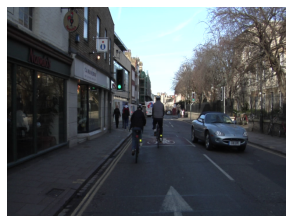

In [0]:
img_f = fnames[0] #open the first image of the val set
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name #label function

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

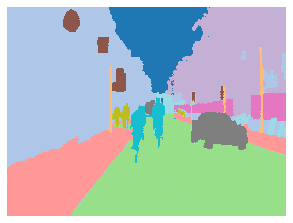

In [0]:
mask = open_mask(get_y_fn(img_f)) #mask
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:]) #image array
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

## Datasets

In [0]:
bs = 8 #batch size

In [0]:
src = (SegmentationItemList.from_folder(path) #getting the data with the validation set
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), tfm_y=True) #databunch + normalizing
        .databunch(bs=bs)
        .normalize(imagenet_stats))

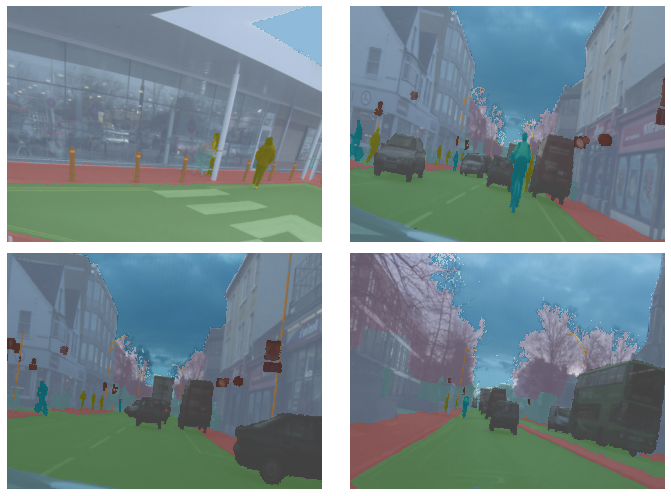

In [0]:
data.show_batch(2, figsize=(10,7)) #show a few examples

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)} #function for label void
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2 #slice

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True) #load model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


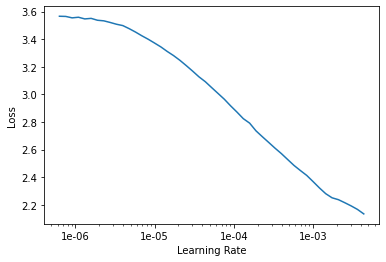

In [0]:
lr_find(learn) #find learning rate
learn.recorder.plot()

In [0]:
lr=2e-3 #slice

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8) #train after finetuning

epoch,train_loss,valid_loss,acc_camvid,time
0,1.167434,0.809560,0.775568,00:45
1,0.788650,0.601950,0.844390,00:42
2,0.642875,0.550517,0.845906,00:43
3,0.537574,0.424422,0.881527,00:43
4,0.540865,0.525503,0.874255,00:43
5,0.501055,0.416622,0.870421,00:43
6,0.439942,0.339366,0.899069,00:43
7,0.434616,0.433475,0.885681,00:43
8,0.385679,0.323482,0.910872,00:43
9,0.333666,0.269010,0.917281,00:43


In [0]:
learn.save('stage-1') #save

In [0]:
learn.load('stage-1'); #load

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr) #select slice

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8) #train again

epoch,train_loss,valid_loss,acc_camvid,time
0,0.289095,0.256382,0.923352,00:43
1,0.274374,0.255108,0.924242,00:44
2,0.270442,0.241855,0.928455,00:44
3,0.275765,0.246913,0.926307,00:45
4,0.280608,0.286717,0.916493,00:45
5,0.284619,0.294893,0.919522,00:45
6,0.298775,0.290632,0.913256,00:45
7,0.319535,0.405866,0.896591,00:45
8,0.324711,0.340362,0.906033,00:45
9,0.292735,0.283540,0.923355,00:45


In [0]:
learn.save('stage-2'); #save it

## Go big

In [0]:
learn=None #reclaim memory
gc.collect()

122

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size #start over
bs=8

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


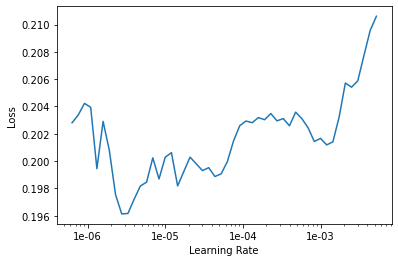

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-6 

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.200345,0.253911,0.926684,00:41
1,0.200119,0.250760,0.927824,00:41
2,0.199301,0.252416,0.927394,00:42
3,0.199934,0.250264,0.927627,00:42
4,0.199955,0.249719,0.928076,00:42
5,0.197831,0.252808,0.927298,00:43
6,0.201085,0.246175,0.929062,00:43
7,0.199506,0.246760,0.928880,00:43
8,0.199222,0.249747,0.928461,00:43
9,0.198096,0.245824,0.929378,00:43


In [0]:
learn.save('stage-1-big') #save

In [0]:
learn.load('stage-1-big'); #load

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.198900,0.246773,0.928935,00:43
1,0.196436,0.244748,0.929733,00:44
2,0.199605,0.246376,0.929147,00:44
3,0.200299,0.244642,0.929323,00:44
4,0.200616,0.247161,0.929222,00:44
5,0.198426,0.244767,0.929418,00:45
6,0.197631,0.247012,0.929262,00:45
7,0.197177,0.246543,0.929184,00:45
8,0.198117,0.245811,0.929254,00:45
9,0.197701,0.247735,0.928984,00:45


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

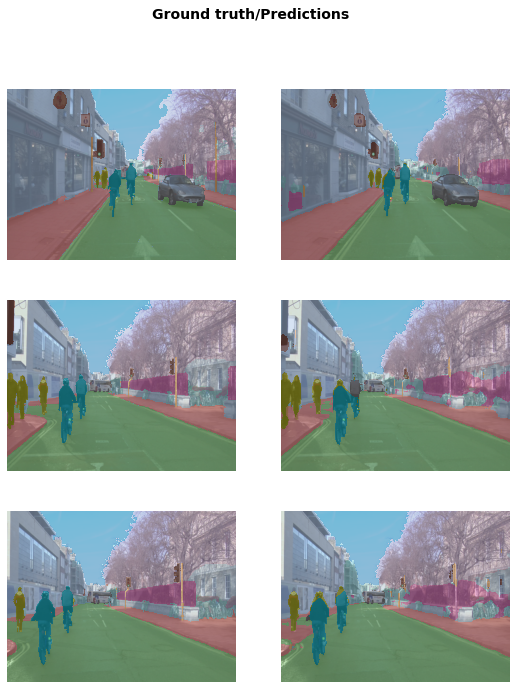

In [0]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [0]:
# start: 480x360

In [0]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________